In [3]:
# Startup code, Importing Packages
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import cv2
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

# Kaggle CNN Cancer Detection

### Exploritory Data Analysis

First, lets see the files that are in the data directory.

In [4]:
os.listdir('histopathologic-cancer-detection')

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

Test and Train are folders containing the training and testing images. train_labels.csv is a csv file that has the image id and the corresponding category.

0 for non-cancerous - 1 for cancerous.

Next, we should see how many images are actually in the train and test folders.

In [5]:
print(f"Images in Train folder: {len(os.listdir('histopathologic-cancer-detection/train'))}")

Images in Train folder: 220025


In [6]:
print(f"Images in Test folder: {len(os.listdir('histopathologic-cancer-detection/test'))}")

Images in Test folder: 57458


In [7]:
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
print(df.shape)


(220025, 2)


In [8]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Above, we can see that each Image has an ID and a label, which is for non-cancerous/cancerous. Next, lets look at how many of each label is present is in the data frame.

In [9]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

<AxesSubplot:>

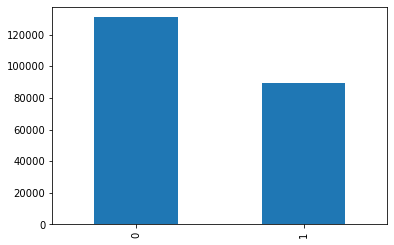

In [10]:
df['label'].value_counts().plot(kind='bar')

Heres a simple histogram showing the difference in count of the 2 labels. For refrence, i'll just pull the first 5 images in the train folder so we can see what they look like.

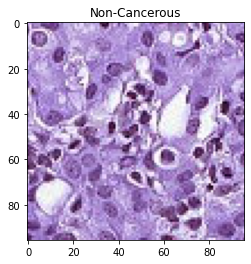

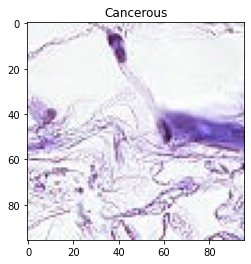

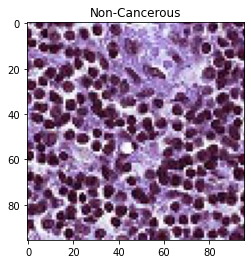

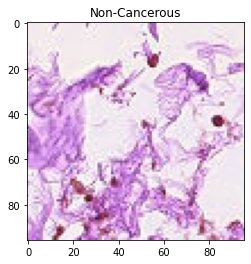

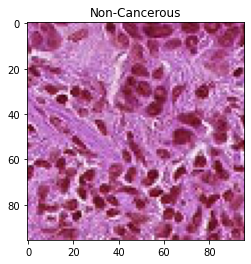

In [11]:
for i in range(5):
    imgs = {}
    img = os.listdir('histopathologic-cancer-detection/train')[i]
    imgs[i] = plt.imshow(cv2.imread('histopathologic-cancer-detection/train'+'/'+img))
    if df.label[i] == 0:
        plt.title("Non-Cancerous")
    else:
        plt.title("Cancerous")
    plt.show()
    


### Data Prep

To start, I want to have an equal number of labels in the data set, so I am going to choose a number and remove images so we can get that number.

In [12]:
# 75,000 seems like a good number, don't want it too big otherwise it will take a long time to run
sample_size = 75000
df_0 = df[df['label'] == 0].sample(sample_size, random_state=12345)
df_1 = df[df['label'] == 1].sample(sample_size, random_state=12345)

df = pd.concat([df_0, df_1], axis = 0).reset_index(drop=True)
df = shuffle(df)

df['label'].value_counts()

1    75000
0    75000
Name: label, dtype: int64

Now, I wanna split this new dataframe into a training and testing set.

In [13]:
# Want to stratify using the dataframe so that the train and test sets have an equal number of each label
strat = df['label']

train, test = train_test_split(df, test_size = 0.20, random_state=123, stratify=strat)

print(train.shape)
print(test.shape)

(120000, 2)
(30000, 2)


In [14]:
train['label'].value_counts()

0    60000
1    60000
Name: label, dtype: int64

In [15]:
test['label'].value_counts()

0    15000
1    15000
Name: label, dtype: int64

We can see above that the training and testing sets have an equal number of labels.

Next, a very important step to limit RAM usage is to create directories that the images can be out in. This will allow us to train the model without it crashing, and for various epochs

In [104]:
# Create a new directory
base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

test_dir = os.path.join(base_dir, 'test_dir')
os.mkdir(test_dir)

# create new folders inside train_dir
zero_images = os.path.join(train_dir, '0_images')
os.mkdir(zero_images)
one_images = os.path.join(train_dir, '1_images')
os.mkdir(one_images)

# create new folders inside test_dir
zero_images = os.path.join(test_dir, '0_images')
os.mkdir(zero_images)
one_images = os.path.join(test_dir, '1_images')
os.mkdir(one_images)

In [75]:
#Create directory for the final test images, titled submission_dir
sub_dir = os.path.join('base_dir', 'submission_dir')
os.mkdir(sub_dir)

images_path = os.path.join(sub_dir, 'images')
os.mkdir(images_path)

In [16]:
# set the image ids to be the indices so that they can be found easier.
df.set_index('id', inplace=True)

In [17]:
df.head()

,label
id,
543a755d7c04428863cd414b0abe156b5c9a55dd,1
8a03f9bded3c57e771af136bbcf160dce4ddaad3,1
7394a9b27a179c2fe85ea875868c356c66cd01b2,0
7cd895d84d8d1879945fcd9edea9b65e9f69a599,1
dc570338ff08c7a46ea2d7cc6072f76532bdb7ff,1


In [ ]:
train_list = list(train['id'])
test_list = list(test['id'])

for image in train_list:
    file_name = image + '.tif'
    target = df.loc[image,'label']
    #So we know which folder it should go in
    if target == 0:
        label = '0_images'
    if target == 1:
        label = '1_images'
    
    source = os.path.join('../KaggleCancerDetection/histopathologic-cancer-detection/train', file_name)
    dest = os.path.join(train_dir, label, file_name)
    shutil.copyfile(source, dest)

for image in test_list:
    file_name = image + '.tif'
    target = df.loc[image,'label']
    #So we know which folder it should go in
    if target == 0:
        label = '0_images'
    if target == 1:
        label = '1_images'
    
    source = os.path.join(r'../KaggleCancerDetection/histopathologic-cancer-detection/train', file_name)
    dest = os.path.join(test_dir, label, file_name)
    shutil.copyfile(source, dest)

In [76]:
#Copying over images from test folder provided
sub_list = os.listdir('../KaggleCancerDetection/histopathologic-cancer-detection/test')
for image in sub_list:
    src = os.path.join('../KaggleCancerDetection/histopathologic-cancer-detection/test', image)
    dest = os.path.join(sub_dir, 'images', image)
    shutil.copyfile(src, dest)

In [18]:
# check how many training images we have in each folder
print(len(os.listdir('base_dir/train_dir/0_images')))
print(len(os.listdir('base_dir/train_dir/1_images')))

60000
60000


In [19]:
# check how many test images we have in each folder
print(len(os.listdir('base_dir/test_dir/0_images')))
print(len(os.listdir('base_dir/test_dir/1_images')))

15000
15000


In [20]:
train_path = 'base_dir/train_dir'
test_path = 'base_dir/test_dir'

num_train_samples = len(train)
num_test_samples = len(test)
train_batch_size = 64
test_batch_size = 64

train_steps = np.ceil(num_train_samples / train_batch_size)
test_steps = np.ceil(num_test_samples / test_batch_size)

In [21]:
img_size=96
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(img_size,img_size),
                                        batch_size=train_batch_size,
                                        class_mode='binary',
                                        shuffle=True)

test_gen = datagen.flow_from_directory(test_path,
                                      target_size=(img_size,img_size),
                                      batch_size=test_batch_size,
                                      class_mode='binary',
                                      shuffle=True)

# Note: shuffle=False causes the test dataset to not be shuffled
test2_gen = datagen.flow_from_directory(test_path,
                                       target_size=(img_size,img_size),
                                       batch_size=1,
                                       class_mode='binary',
                                       shuffle=False)

Found 120000 images belonging to 2 classes.
Found 30000 images belonging to 2 classes.
Found 30000 images belonging to 2 classes.


In [22]:
# Saves the model so that we don't have to train it again when using on other data sets
from tensorflow.keras.callbacks import ModelCheckpoint
model_dir = 'CNN.h5'
checkpoint = ModelCheckpoint(model_dir, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')

In [50]:
model=Sequential()
model.add(Conv2D(32,(3,3),strides=1,padding='Same',activation='relu',input_shape=(96, 96, 3)))
model.add(Conv2D(64,(3,3), strides=1,padding= 'Same', activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(1, activation = "sigmoid"))
optimizer = Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer = optimizer , loss = "binary_crossentropy", metrics=["accuracy"])

In [51]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 96, 96, 64)       256       
 hNormalization)                                                 
                                                                 
 flatten_1 (Flatten)         (None, 589824)            0         
                                                                 
 dropout_1 (Dropout)         (None, 589824)            0         
                                                                 
 dense_1 (Dense)             (None, 1)                 589825    
                                                      

In [25]:
history = model.fit(train_gen, validation_data=test_gen,epochs=5, verbose=1, callbacks = checkpoint)

Epoch 1/5
1875/1875 [==============================] - ETA: 0s - loss: 0.5232 - accuracy: 0.7752
Epoch 1: val_accuracy improved from -inf to 0.76713, saving model to CNN.h5
1875/1875 [==============================] - 1143s 610ms/step - loss: 0.5232 - accuracy: 0.7752 - val_loss: 0.5401 - val_accuracy: 0.7671
Epoch 2/5
1875/1875 [==============================] - ETA: 0s - loss: 0.4141 - accuracy: 0.8164
Epoch 2: val_accuracy improved from 0.76713 to 0.80123, saving model to CNN.h5
1875/1875 [==============================] - 954s 509ms/step - loss: 0.4141 - accuracy: 0.8164 - val_loss: 0.4514 - val_accuracy: 0.8012
Epoch 3/5
1875/1875 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.8440
Epoch 3: val_accuracy improved from 0.80123 to 0.80387, saving model to CNN.h5
1875/1875 [==============================] - 962s 513ms/step - loss: 0.3601 - accuracy: 0.8440 - val_loss: 0.4357 - val_accuracy: 0.8039
Epoch 4/5
1875/1875 [==============================] - ETA: 0s 

For fitting the model, I chose 5 epochs. This is a low number of them, but due to computational and time constraints, it would have taken a very long time with a number that would be better.

In [42]:
info_df = pd.DataFrame(history.history)
info_df

,loss,accuracy,val_loss,val_accuracy
0,0.523245,0.775233,0.540058,0.767133
1,0.414146,0.816367,0.451387,0.801233
2,0.360136,0.844017,0.435720,0.803867
3,0.293897,0.878083,0.557534,0.793933
4,0.233271,0.906600,0.633728,0.768700


Looking at the dataframe of the information from the 5 epochs, we can see that the validation accuracy peeked at epoch number 3, with val_accuracy = 0.804.

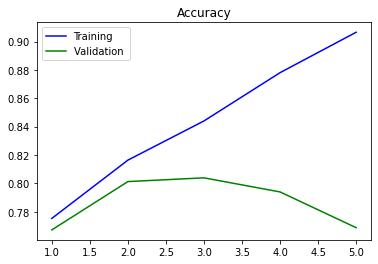

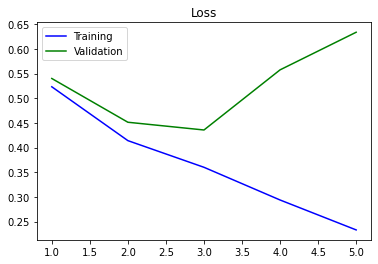

In [39]:
plt.plot(range(1,6,1), history.history['accuracy'], 'b', label='Training ')
plt.plot(range(1,6,1), history.history['val_accuracy'], 'g', label='Validation ')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(range(1,6,1), history.history['loss'], 'b', label='Training')
plt.plot(range(1,6,1),  history.history['val_loss'], 'g', label='Validation')
plt.title('Loss')
plt.legend()

plt.show()

Looking at the graphs showing the accuracy and loss of the model, we can see that for both loss and accuracy, we see the best value at 3 for validation. 

For time's sake, I have already saved the model using keras, so now I am goign to load it again so that we can evaluate it using the 

In [43]:
from keras.models import load_model

CNN = load_model('./CNN.h5')

In [45]:
CNN.evaluate_generator(test2_gen, steps = len(test), verbose=1)

   30/30000 [..............................] - ETA: 1:48 - loss: 0.3271 - accuracy: 0.8667

C:\Users\jacob\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


30000/30000 [==============================] - 105s 3ms/step - loss: 0.4357 - accuracy: 0.8039


[0.4357210397720337, 0.8038666844367981]

In [46]:
predicted_test2 = CNN.predict_generator(test2_gen, steps=len(test), verbose=1)

   31/30000 [..............................] - ETA: 1:42

C:\Users\jacob\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


30000/30000 [==============================] - 103s 3ms/step


In [47]:
predicted_test2 = np.round(predicted_test2)

In [103]:
from sklearn.metrics import classification_report
test2_true = test2_gen.classes
report = classification_report(test2_true, predicted_test2)
print(report)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81     15000
           1       0.81      0.79      0.80     15000

    accuracy                           0.80     30000
   macro avg       0.80      0.80      0.80     30000
weighted avg       0.80      0.80      0.80     30000



Above is the classification report on predicting on the testing set, with an accuracy of 0.80, it seems to be predicting well on the testing set.

Lets look at the first 5 images in the test folder that will be used for the submission.

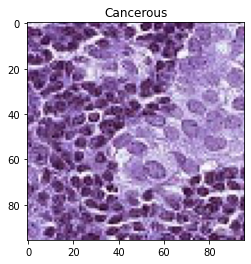

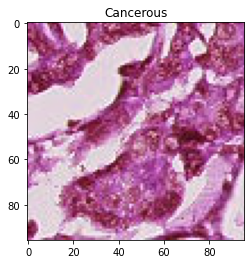

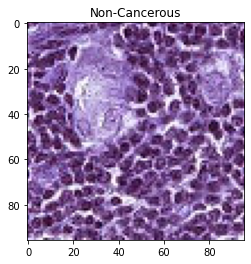

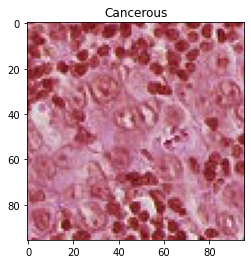

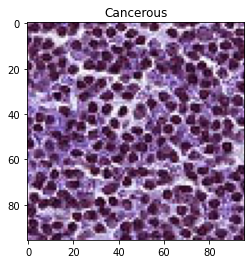

In [52]:
for i in range(5):
    imgs = {}
    img = os.listdir('histopathologic-cancer-detection/test')[i]
    imgs[i] = plt.imshow(cv2.imread('histopathologic-cancer-detection/test'+'/'+img))
    if df.label[i] == 0:
        plt.title("Non-Cancerous")
    else:
        plt.title("Cancerous")
    plt.show()


In [77]:
print(f"# of Images for submission.csv: {len(os.listdir('base_dir/submission_dir/images'))}")

# of Images for submission.csv: 57458


In [78]:
sub_path = 'base_dir/submission_dir/'
sub_gen = datagen.flow_from_directory(sub_path,
                                      target_size=(96,96),
                                      batch_size=1,
                                      class_mode='categorical',
                                      shuffle=False)

Found 57458 images belonging to 1 classes.


In [79]:
final_preds = model_saved.predict_generator(sub_gen, steps=len(os.listdir('base_dir/submission_dir/images')), verbose=1)
final_preds

   28/57458 [..............................] - ETA: 3:39

C:\Users\jacob\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


57458/57458 [==============================] - 303s 5ms/step


array([[0.5081355 ],
       [0.17466858],
       [0.27828035],
       ...,
       [0.9497721 ],
       [0.20145911],
       [0.96373713]], dtype=float32)

In [96]:
category_data = 1 - final_preds

In [100]:
submission = pd.read_csv('histopathologic-cancer-detection/sample_submission.csv')
submission.head()
submission.label = np.round(category_data)
submission.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.0
1,95596b92e5066c5c52466c90b69ff089b39f2737,1.0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,1.0
3,2c35657e312966e9294eac6841726ff3a748febf,1.0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.0


In [101]:
submission.to_csv('submission.csv', header=True, index=False)

## Analysis and Conclusion

So the score I got on the Kaggle competition was 0.5014, which is not very good. Ideally I would like it to be above 0.80. This bad accuracy comes down to how the model was trained. The model was not fitted with enough epochs to train the model so we achieve an acceptable accuracy. This comes down to a lack of computational power and time, meaning that it would have been extremely difficult for me to fit the model with the appropriate number of epochs, probably 20-25. This means that the model was slightly underfitted, it did not perform as poorly on the training set, with an accuracy of 0.80, but it was not flexible enough to work well on a seperate data set. 

In the future I would allow the model to run through many more epochs. I could also choose much smaller data sets to make that difference, but again the computational restraints would have made the process extremely frustrating, so the system would have to change to allow for a more in-depth model. 

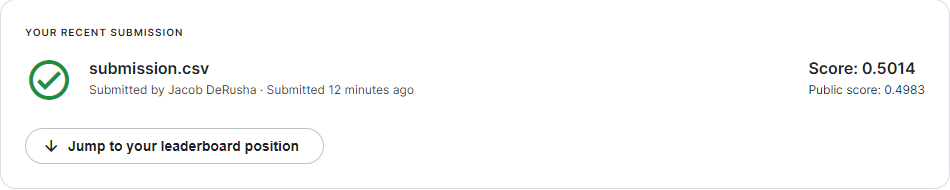